<a href="https://colab.research.google.com/github/TzabarDolev/LittleBigScience/blob/main/LaneDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TypeError: ignored

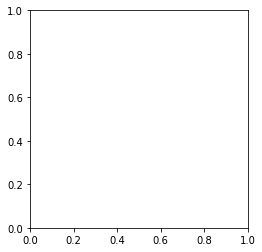

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Returns edges detected in an image
def canny_edge_detector(frame):
    # Convert to grayscale as only image intensity needed for gradients
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # 5x5 gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Canny edge detector with minVal of 50 and maxVal of 150
    canny = cv2.Canny(blur, 50, 150)

    return canny


# Returns a masked image
def ROI_mask(image):
    height = image.shape[0]
    width = image.shape[1]

    # A triangular polygon to segment the lane area and discarded other irrelevant parts in the image
    # Defined by three (x, y) coordinates
    polygons = np.array([
        [(0, height), (round(width / 2), round(height / 2)), (1000, height)]
    ])

    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)  ## 255 is the mask color

    # Bitwise AND between canny image and mask image
    masked_image = cv2.bitwise_and(image, mask)

    return masked_image


def get_coordinates(image, params):
    slope, intercept = params
    y1 = image.shape[0]
    y2 = int(y1 * (3 / 5))  # Setting y2 at 3/5th from y1
    x1 = int((y1 - intercept) / slope)  # Deriving from y = mx + c
    x2 = int((y2 - intercept) / slope)

    return np.array([x1, y1, x2, y2])


# Returns averaged lines on left and right sides of the image
def avg_lines(image, lines):
    left = []
    right = []

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)

        # Fit polynomial, find intercept and slope
        params = np.polyfit((x1, x2), (y1, y2), 1)
        slope = params[0]
        y_intercept = params[1]

        if slope < 0:
            left.append((slope, y_intercept))  # Negative slope = left lane
        else:
            right.append((slope, y_intercept))  # Positive slope = right lane

    # Avg over all values for a single slope and y-intercept value for each line

    left_avg = np.average(left, axis=0)
    right_avg = np.average(right, axis=0)

    # Find x1, y1, x2, y2 coordinates for left & right lines
    left_line = get_coordinates(image, left_avg)
    right_line = get_coordinates(image, right_avg)

    return np.array([left_line, right_line])


# Draws lines of given thickness over an image
def draw_lines(image, lines, thickness):
    print(lines)
    line_image = np.zeros_like(image)
    color = [0, 0, 255]

    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)

    # Merge the image with drawn lines onto the original.
    combined_image = cv2.addWeighted(image, 0.8, line_image, 1.0, 0.0)

    return combined_image

# Load input image (ideally this should be a frame extracted from a video)
inputimage = cv2.imread("https://github.com/udacity/CarND-LaneLines-P1/blob/master/test_images/solidYellowCurve.jpg?raw=true")

plt.figure()
plt.imshow(cv2.cvtColor(inputimage, cv2.COLOR_BGR2RGB))
# plt.imshow(inputimg) # Incorrect because opencv stores images in BGR format

#Image source taken from this video :
# https://github.com/udacity/CarND-LaneLines-P1/blob/master/test_videos/solidWhiteRight.mp4

# Canny edge detection
canny_edges = canny_edge_detector(inputimage)
plt.figure()
plt.imshow(cv2.cvtColor(canny_edges, cv2.COLOR_BGR2RGB))
plt.show()

# Remove irrelevant segments of the image and retain only the lane portion
cropped_image = ROI_mask(canny_edges)
plt.figure()
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.show()

#Hough transform to detect lanes from the detected edges
lines = cv2.HoughLinesP(
    cropped_image,
    rho=2,              #Distance resolution in pixels
    theta=np.pi / 180,  #Angle resolution in radians
    threshold=100,      #Min. number of intersecting points to detect a line
    lines=np.array([]), #Vector to return start and end points of the lines indicated by [x1, y1, x2, y2]
    minLineLength=40,   #Line segments shorter than this are rejected
    maxLineGap=25       #Max gap allowed between points on the same line
)

# Visualisations
averaged_lines = avg_lines (inputimage, lines)              #Average the Hough lines as left or right lanes
combined_image = draw_lines(inputimage, averaged_lines, 5)  #Combine the averaged lines on the real frame
plt.figure()
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.show()

